In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
#import distance
from nltk.stem import PorterStemmer

import string
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation

import re
from bs4 import BeautifulSoup

from nltk.tokenize import word_tokenize
  
ps = PorterStemmer()

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Projects/1_quora_duplicate_flaging/')

sys.path.append('/content/drive/MyDrive/Projects/env')

sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/Projects/1_quora_duplicate_flaging/',
 '/content/drive/MyDrive/Projects/env']

In [ ]:

from fuzzywuzzy import fuzz
import distance
from wordcloud import WordCloud, STOPWORDS

/content/drive/MyDrive/Projects/env/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Projects/1_quora_duplicate_flaging/train.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


### Checking basic info of the dataframe

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [ ]:
# there are some missing values but they are less in number, so we just drop them

In [ ]:
df.dropna(inplace= True )

In [ ]:
df.reset_index(inplace= True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404287 entries, 0 to 404286
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   index         404287 non-null  int64 
 1   id            404287 non-null  int64 
 2   qid1          404287 non-null  int64 
 3   qid2          404287 non-null  int64 
 4   question1     404287 non-null  object
 5   question2     404287 non-null  object
 6   is_duplicate  404287 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 21.6+ MB


## Data Preprocessing

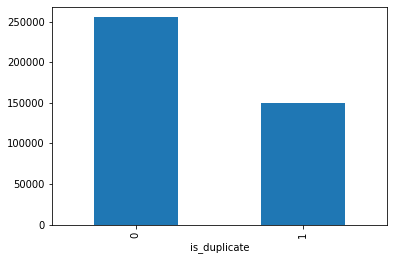

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
len(df)  # total length of the dataframe

404287

In [ ]:
ser=pd.concat([df['qid1'],df['qid2']])

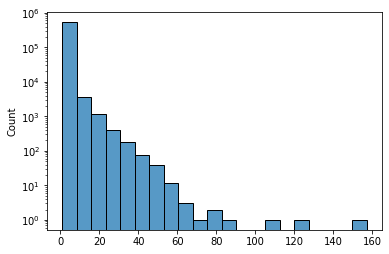

In [ ]:
#ser.value_counts().plot.hist(bins=40,)
sns.histplot(ser.value_counts(),log_scale=(False, True)) # y logscaled plot

In [ ]:
len(ser.value_counts())  # these are uniques questions

537929

In [ ]:
np.sum(ser.value_counts()!=1)  # not uniques questions 

111778

In [ ]:
df[df.isnull().any(1)]  # no nan values

,index,id,qid1,qid2,question1,question2,is_duplicate


## Feature Derivation

In [ ]:
 


def preprocess(x):
    
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    
    return x
    
    


In [ ]:
df['both_ques'] = df['question1']+' && ' + df['question2']

In [ ]:
df['both_ques']= df.both_ques.str.lower()

# this wil get me count and matching numbers

def solve(s):
    try:
        [s0,s1] = s.split(' && ')
    except:
        s0 = s.split(' && ')[0]
        s1=' '
    s0List  = s0.split(" ")
    
    s1List  = s1.split(" ")
    
    return len(list(set(s0List)&set(s1List))),(len(s0List+s1List)),len(list(set(s0List)&set(s1List)))/(len(s0List+s1List))

## Created three new features, total counts of words, total common counts, share percentage(max=0.5, min=0)

In [ ]:
df.loc[:,['common_count', 'total_count', 'match_count']]=pd.DataFrame(df.both_ques.apply(solve).tolist(), columns=['common_count', 'total_count', 'match_count'])



In [ ]:
df['match_count']

0         0.384615
1         0.190476
2         0.166667
3         0.000000
4         0.100000
            ...   
404282    0.407407
404283    0.294118
404284    0.142857
404285    0.023810
404286    0.444444
Name: match_count, Length: 404287, dtype: float64

In [ ]:
 df

,index,id,qid1,qid2,question1,question2,is_duplicate,both_ques,common_count,total_count,match_count
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,what is the step by step guide to invest in sh...,10,26,0.384615
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,what is the story of kohinoor (koh-i-noor) dia...,4,21,0.190476
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,how can i increase the speed of my internet co...,4,24,0.166667
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,why am i mentally very lonely? how can i solve...,0,20,0.000000
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"which one dissolve in water quikly sugar, salt...",2,20,0.100000
...,...,...,...,...,...,...,...,...,...,...,...
404282,404285,404285,433578,379845,How many keywords are there in the Racket prog...,How many keywords are there in PERL Programmin...,0,how many keywords are there in the racket prog...,11,27,0.407407
404283,404286,404286,18840,155606,Do you believe there is life after death?,Is it true that there is life after death?,1,do you believe there is life after death? && i...,5,17,0.294118
404284,404287,404287,537928,537929,What is one coin?,What's this coin?,0,what is one coin? && what's this coin?,1,7,0.142857
404285,404288,404288,537930,537931,What is the approx annual cost of living while...,I am having little hairfall problem but I want...,0,what is the approx annual cost of living while...,1,42,0.023810


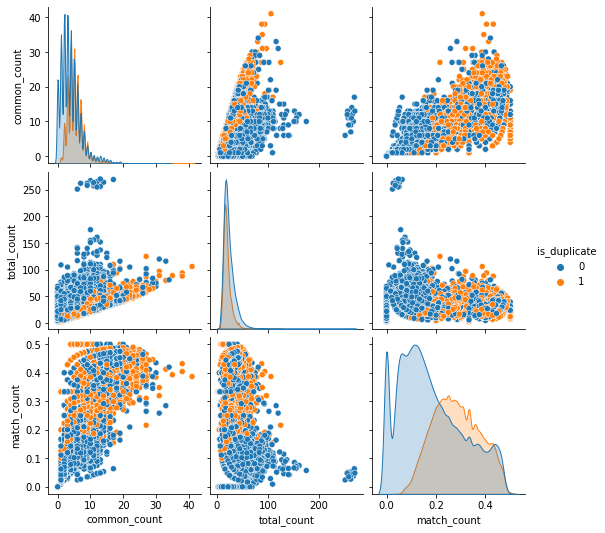

In [ ]:

sns.pairplot(df[['common_count', 'total_count', 'match_count', 'is_duplicate']], hue='is_duplicate', vars=['common_count', 'total_count', 'match_count'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


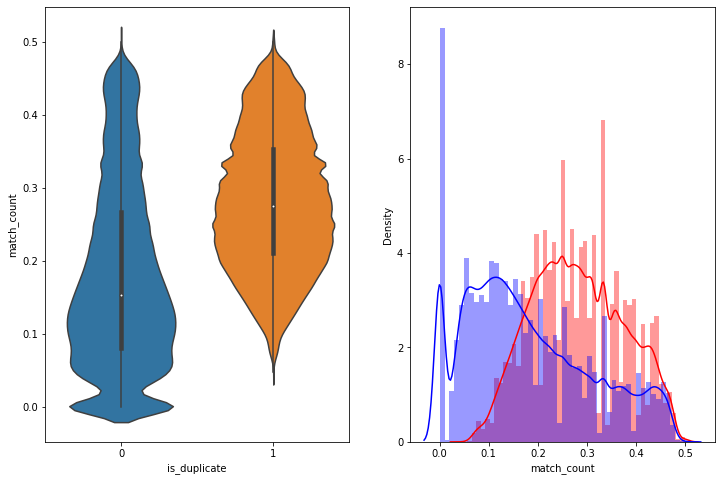

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'match_count', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['match_count'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['match_count'][0:] , label = "0" , color = 'blue' )
plt.show()

## Avove, we see apart from match count none is seperable,so we just keep match count in features

## Adding more advanced features


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>

- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>

- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>

- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>


- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
        
- __last_word_eq__ :  Check if last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>


- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
   
    
    #  http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
df=extract_features(df)

token features...
fuzzy features..


In [ ]:
df.to_csv("/content/drive/MyDrive/Projects/1_quora_duplicate_flaging/fully_processec_df.csv")

## Applying some preprocessing before applying tfidf

In [ ]:
df['both_ques_wsw']= df['both_ques'].apply(preprocess)

In [ ]:
df['both_ques_wsw']

0         what is the step by step guide to invest in sh...
1         what is the story of kohinoor  koh i noor  dia...
2         how can i increase the speed of my internet co...
3         why am i mentally very lonely  how can i solve...
4         which one dissolve in water quikly sugar  salt...
                                ...                        
404282    how many keywords are there in the racket prog...
404283    do you believe there is life after death     i...
404284              what is one coin     what is this coin 
404285    what is the approx annual cost of living while...
404286    what is like to have sex with cousin     what ...
Name: both_ques_wsw, Length: 404287, dtype: object

In [ ]:
# removing stopwords and punctuations 

In [ ]:
df['both_ques_wsw']= df['both_ques_wsw'].apply(remove_stopwords).apply(strip_punctuation)

In [ ]:
def stem_apply(x):  # steming words
    #words= word_tokenize(x)
    return ' '.join([ps.stem(word) for word in x.split()]) 
    

In [ ]:
from time import time as t
s= t()
#df['both_ques_wsw']=df['both_ques_wsw'].apply(stem_apply)
df['both_ques_wsw']=df['both_ques_wsw'].apply(stem_apply)

e=t()
e-s


98.05633592605591

In [ ]:
# def textPreprocessing(data): # this is extremly slow, need to fix this 
#     removePunctuation = [ char for char in data if char not in string.punctuation ]
#     sentences = ''.join(removePunctuation)
#     words = sentences.split()
#     removeStopwords = [ word for word in words if word not in stopwords.words('english')]
#     return removeStopwords


## Making TFIDF vectord

In [ ]:
import time 
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer
wordVector = CountVectorizer()

start  =time.time()
finalWordVectorCreator = wordVector.fit(df['both_ques_wsw'])
end = time.time()
end-start

4.532113552093506

In [ ]:
#finalWordVectorCreator.vocabulary_

In [ ]:
len(finalWordVectorCreator.vocabulary_)

65209

In [ ]:
tfidfObject = TfidfTransformer(smooth_idf=True)
bow1 = finalWordVectorCreator.transform(df['question1'])
#Create Features
features1 = tfidfObject.fit_transform(bow1)  # features for ques 1

In [ ]:
bow2 = finalWordVectorCreator.transform(df['question2'])

features2 = tfidfObject.fit_transform(bow2)   # features for ques 2

In [ ]:
features1.shape, features2.shape

((404287, 65209), (404287, 65209))

In [ ]:
features1

<404287x65209 sparse matrix of type '<class 'numpy.float64'>'
	with 2431538 stored elements in Compressed Sparse Row format>

In [ ]:
# features1 and 2 are sparse array can not be handled with numpy, will have to use scipy sparse

In [ ]:
from scipy import sparse

In [ ]:
r1 = sparse.csr_matrix.multiply((features1-features2),(features1-features2))
#r1 = sparse.csr_matrix.multiply(features1, features1)
r2= sparse.csr_matrix.multiply(features1,features2)

In [ ]:
dis = sparse.csr_matrix.sum(r1,1)

In [ ]:
dot = sparse.csr_matrix.sum(r2,1)

In [ ]:
dis = np.array(np.sqrt(dis)).ravel()
dot = np.array(np.sqrt(dot)).ravel()

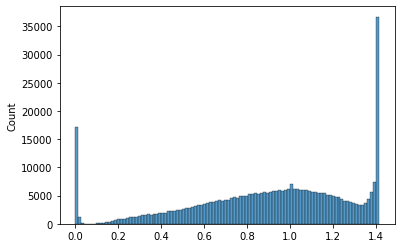

In [ ]:
sns.histplot(dis)

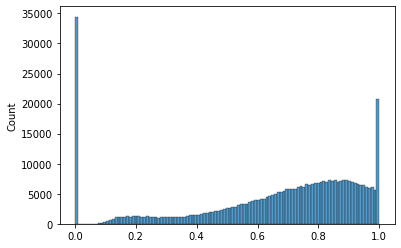

In [ ]:
sns.histplot(dot)

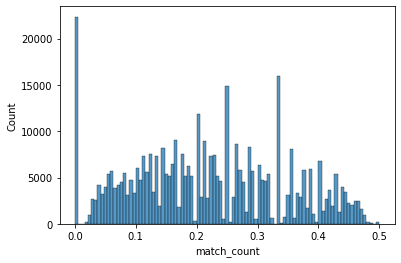

In [ ]:
sns.histplot(df['match_count'])

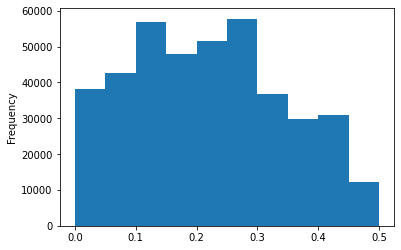

In [ ]:
df['match_count'].plot(kind='hist')

In [ ]:
ind=np.where(dis<0.06)

In [ ]:
#df.to_csv("/content/drive/MyDrive/Projects/1_quora_duplicate_flaging/fully_processec_df.csv")

- dot product of features vector 
- distance between features vector 

In [ ]:
df['dot_new']= dot  

In [ ]:
df['dist']=dis

## Again, some visualization

In [ ]:
df.columns.values

array(['index', 'id', 'qid1', 'qid2', 'question1', 'question2',
       'is_duplicate', 'both_ques', 'common_count', 'total_count',
       'match_count', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio',
       'both_ques_wsw', 'dot_new', 'dist'], dtype=object)

In [ ]:
features_col= [
       'match_count', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'dot_new', 'dist','is_duplicate']

In [ ]:
features_col[:-1]  # total 18 features

['match_count',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio',
 'dot_new',
 'dist']

In [ ]:

#sns.pairplot( df[features_col], hue='is_duplicate', vars = features_col[:-1] )
#plt.show()

KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7ff7bcc034d0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
#df.to_csv("/content/drive/MyDrive/Projects/1_quora_duplicate_flaging/fully_processec_df.csv")

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Projects/1_quora_duplicate_flaging/fully_processec_df.csv")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


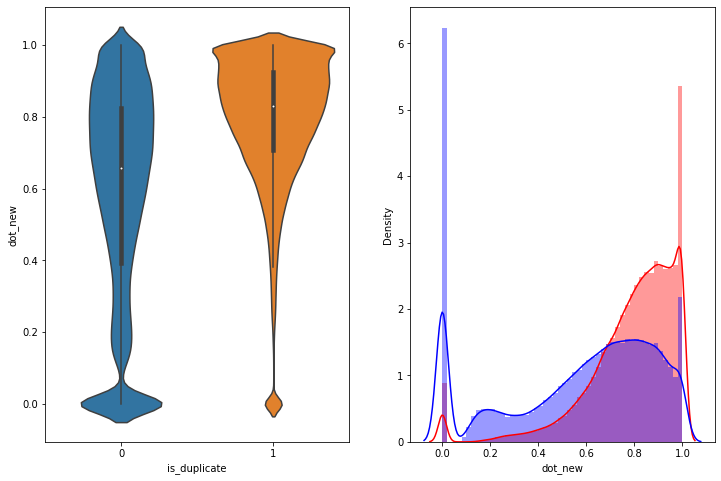

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'dot_new', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['dot_new'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['dot_new'][0:] , label = "0" , color = 'blue' )
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


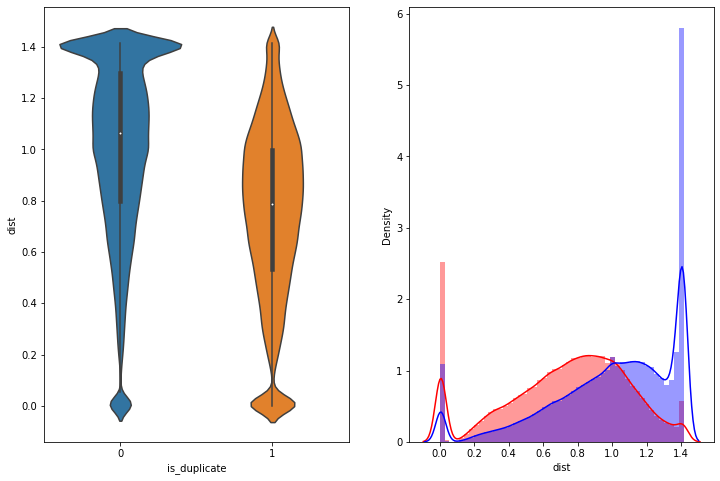

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'dist', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['dist'] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['dist'] , label = "0" , color = 'blue' )
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


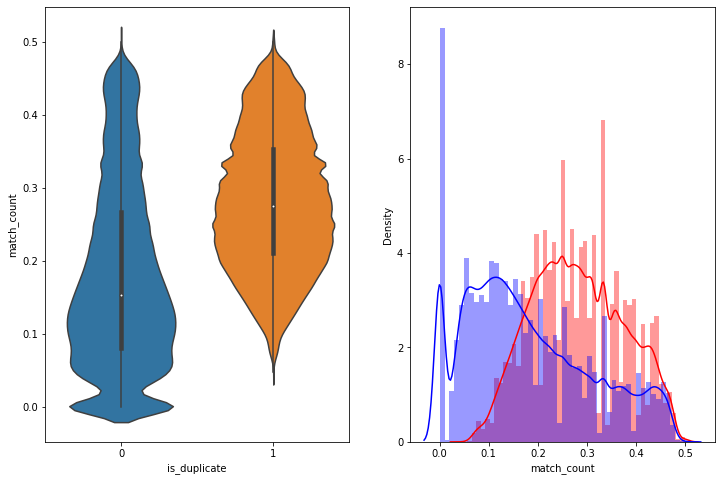

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


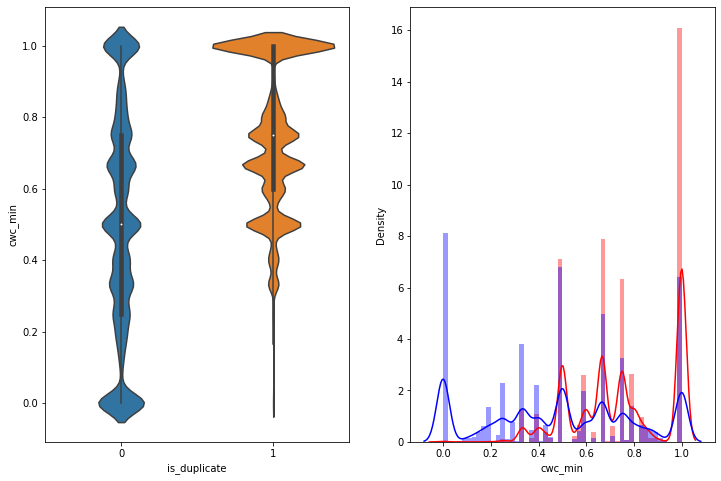

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


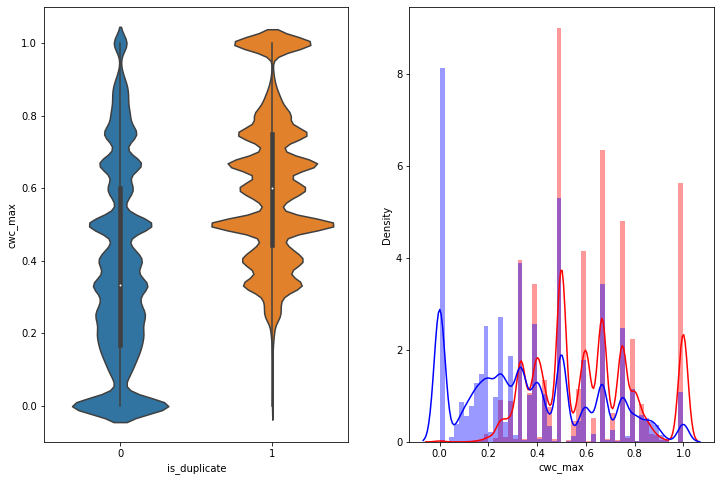

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


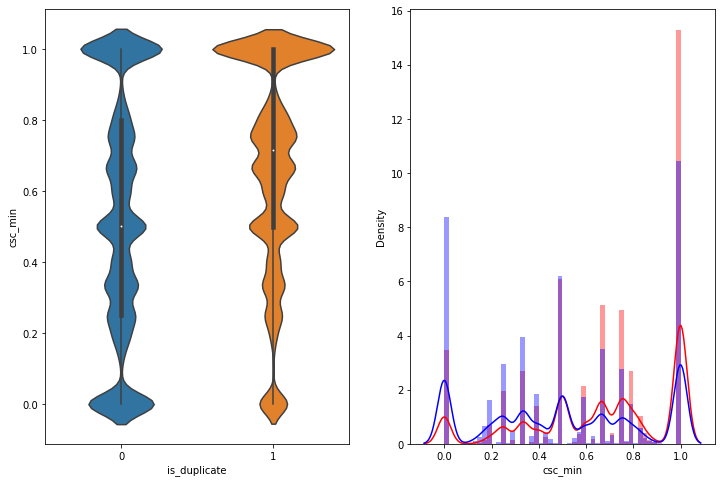

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


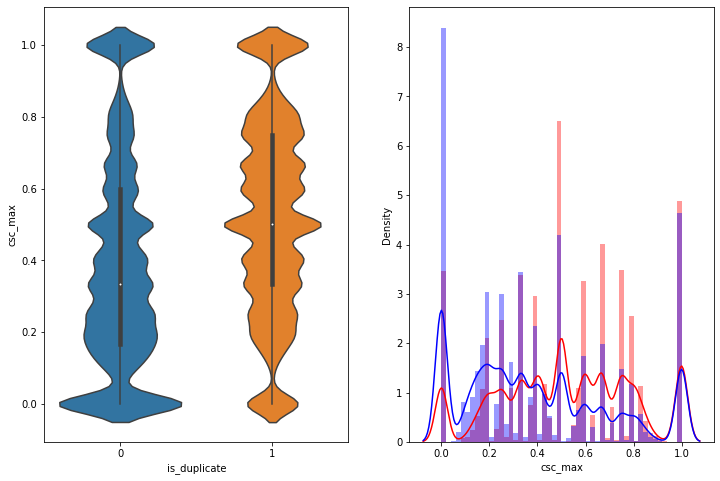

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


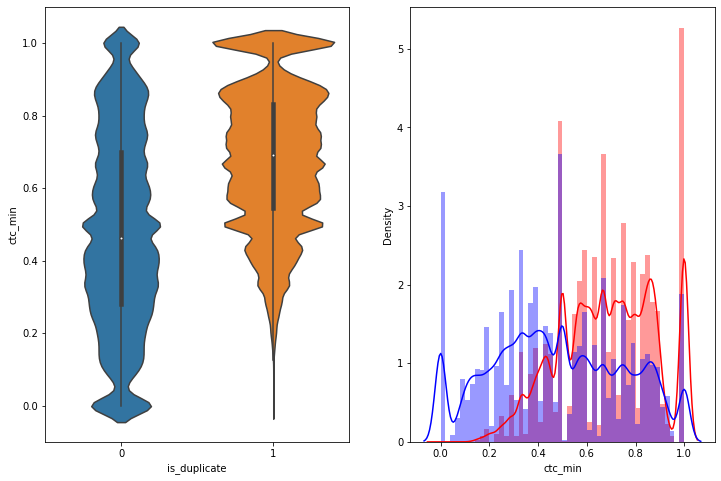

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


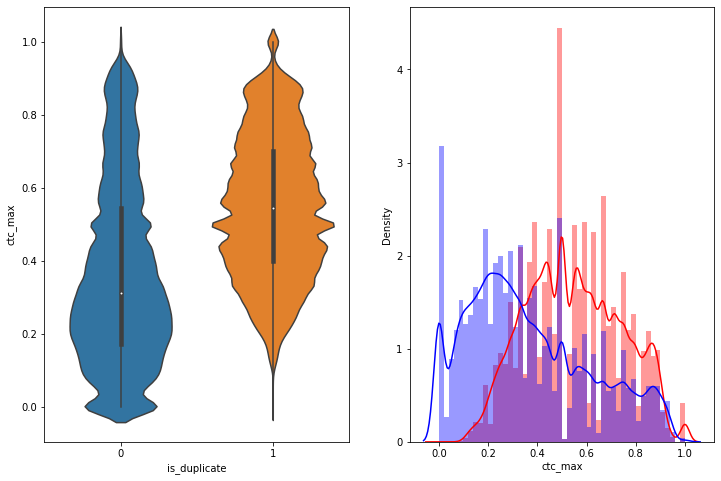

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


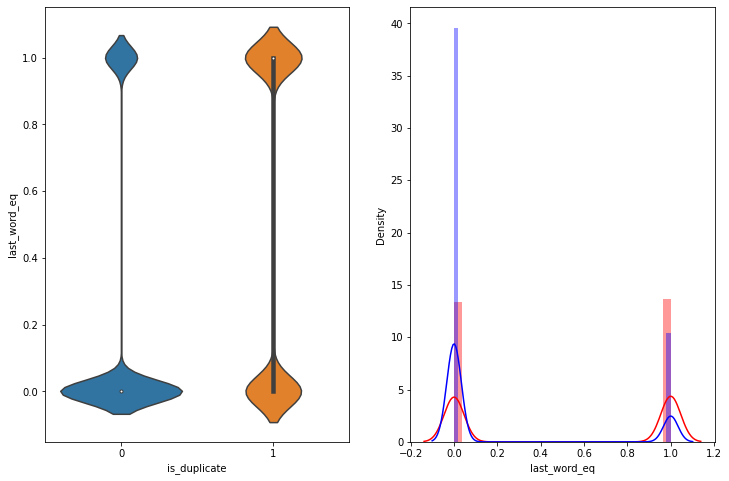

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


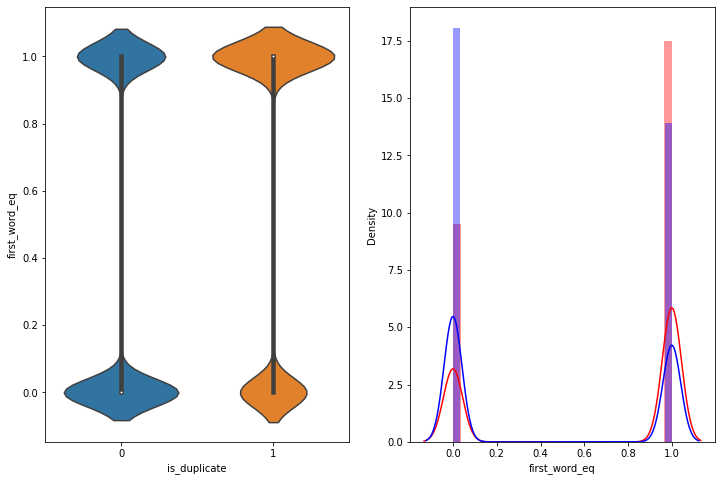

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


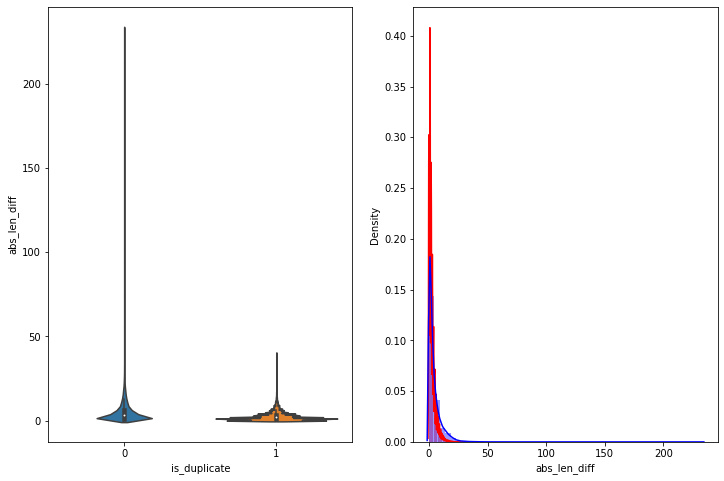

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


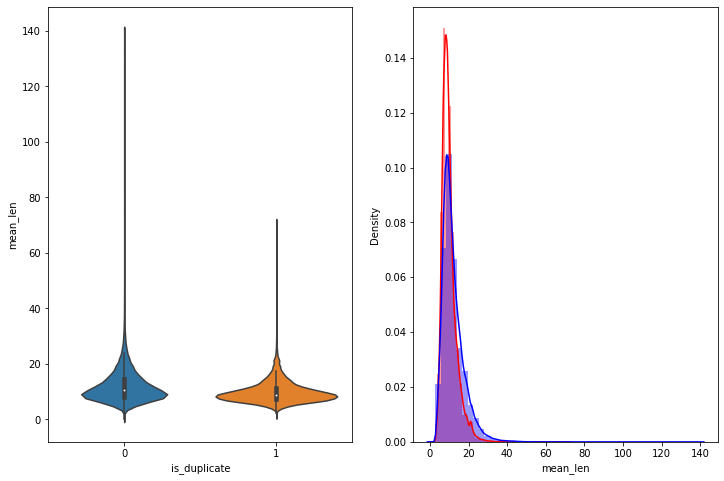

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


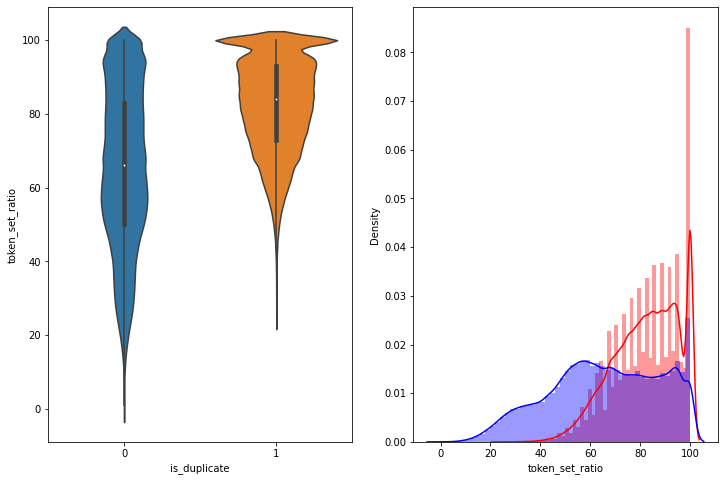

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


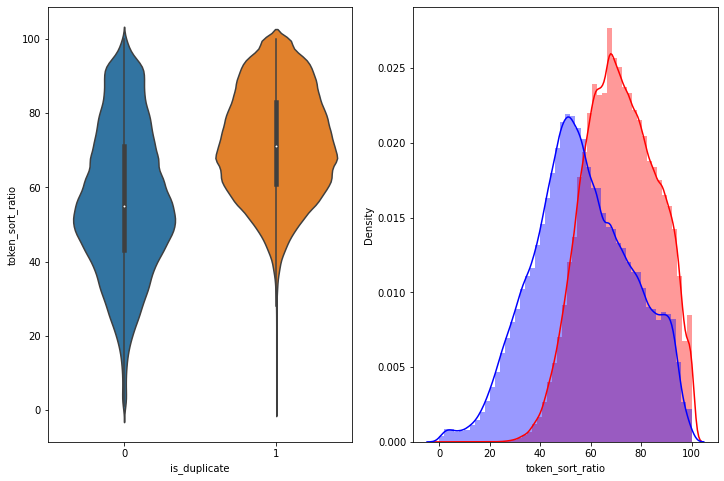

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


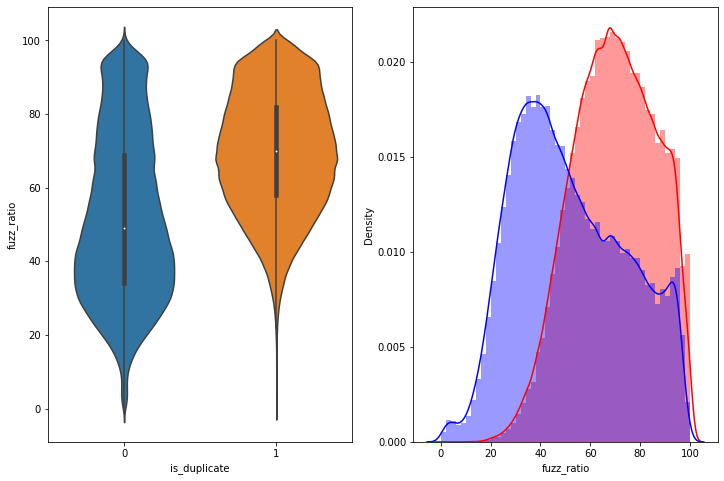

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


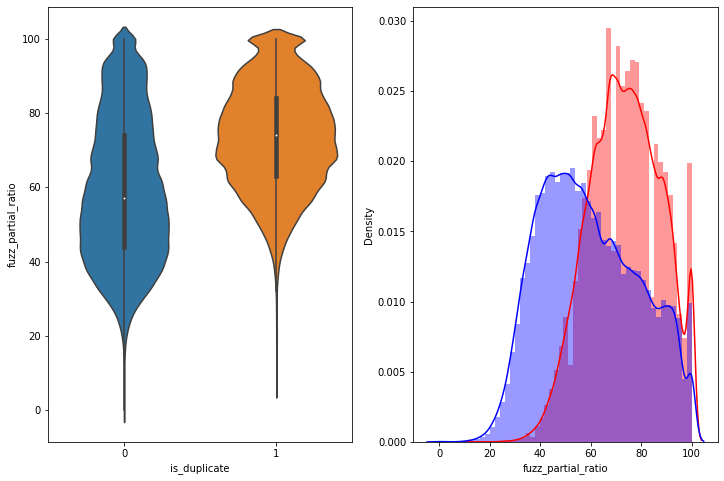

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


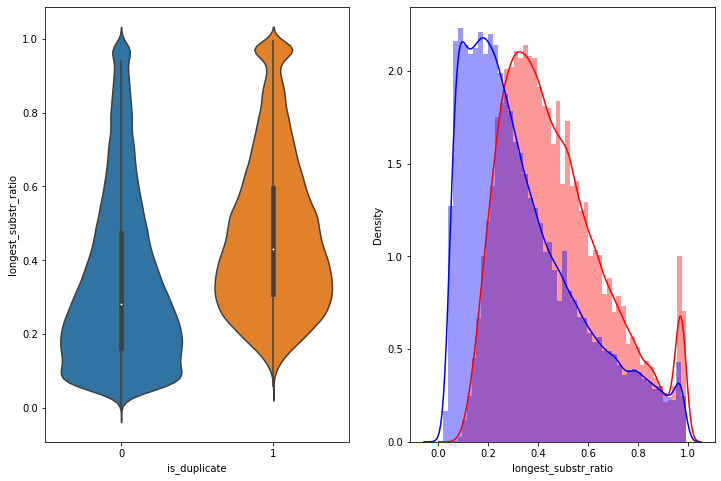

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


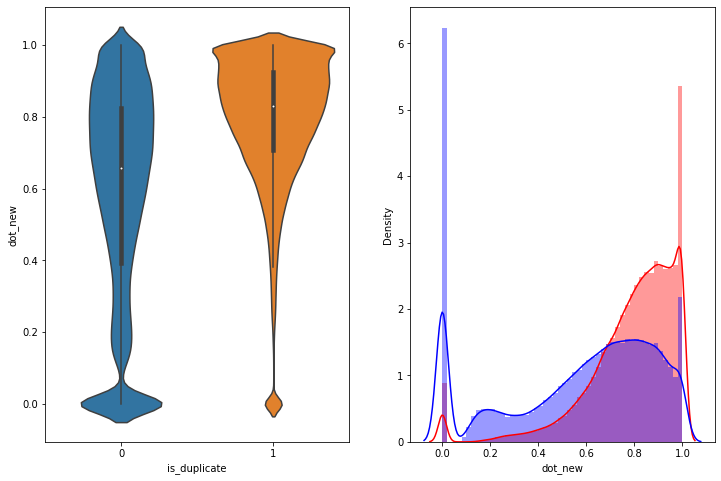

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


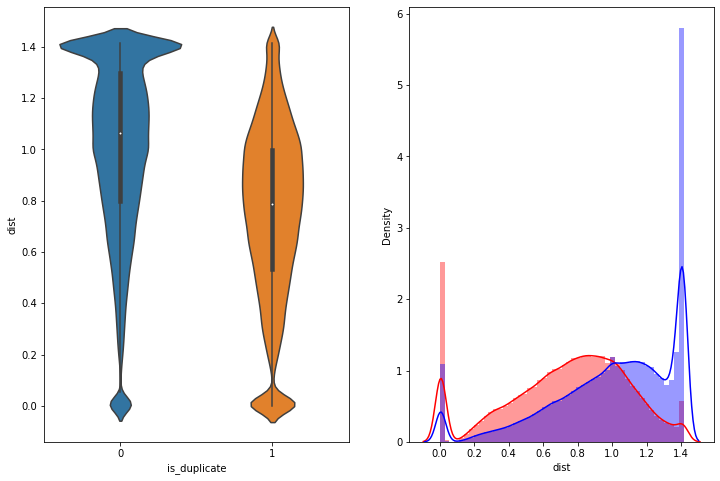

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate

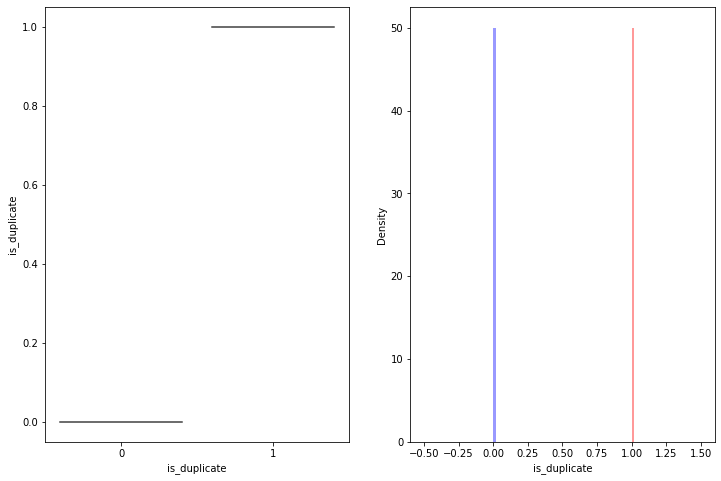

In [ ]:
for col in features_col:
  plt.figure(figsize=(12, 8))

  plt.subplot(1,2,1)
  sns.violinplot(x = 'is_duplicate', y = col, data = df)

  plt.subplot(1,2,2)
  sns.distplot(df[df['is_duplicate'] == 1.0][col][0:] , label = "1", color = 'red')
  sns.distplot(df[df['is_duplicate'] == 0.0][col][0:] , label = "0" , color = 'blue' )
  plt.show()

## We see some of the above features are able to seperate the label

In [ ]:
## 

## Making up the features array

In [ ]:
features_col= [
       'match_count', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq',
       'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',
       'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio', 'dot_new', 'dist','is_duplicate']

In [ ]:
X = df.loc[:,features_col[:-1]].values
y = df['is_duplicate'].values

In [ ]:
X

array([[0.38461538, 0.99980004, 0.83319447, ..., 0.98275862, 0.98716102,
        0.22588988],
       [0.19047619, 0.79984003, 0.39996   , ..., 0.59615385, 0.8953269 ,
        0.62990435],
       [0.16666667, 0.39992002, 0.33327779, ..., 0.16666667, 0.74062058,
        0.95024329],
       ...,
       [0.14285714, 0.999001  , 0.49975012, ..., 0.44444444, 0.95075121,
        0.43834263],
       [0.02380952, 0.        , 0.        , ..., 0.05263158, 0.10894836,
        1.40579533],
       [0.44444444, 0.99966678, 0.99966678, ..., 0.60526316, 0.99996059,
        0.01255559]])

In [ ]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split

# from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
# y= y.ravel()

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=18)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.metrics import f1_score


In [ ]:
model = DecisionTreeClassifier(max_depth=8)

In [ ]:
cv_results = cross_validate(model, X_train, y_train, scoring= 'f1_macro',cv=5,return_train_score= True, verbose=3,n_jobs=-1) 
# verbose, print computation process, more number means it will print more frequently
sorted(cv_results.keys())
#['fit_time', 'score_time', 'test_score']

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished


['fit_time', 'score_time', 'test_score', 'train_score']

In [ ]:
from sklearn.metrics import confusion_matrix
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
cv_results['test_score'], cv_results['train_score']

(array([0.72937619, 0.73443802, 0.73320088, 0.73245479, 0.72962352]),
 array([0.73409055, 0.73584294, 0.73489654, 0.73590919, 0.73586867]))

In [ ]:
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
y_train_pred= model.predict(X_train)
y_test_pred= model.predict(X_test)

In [ ]:
from sklearn.metrics import log_loss

log_loss(y_test, y_test_pred), log_loss(y_train, y_train_pred)

(9.117313083457677, 8.93040589287146)

In [ ]:
log_loss(y_test, np.random.choice([0,1],len(y_test))), log_loss(y_train, np.random.choice([0,1],len(y_train))) 
# this is log score for random answer

(17.202576723792998, 17.271722346665246)

In [ ]:
f1_score(y_test, y_test_pred), f1_score(y_train, y_train_pred)

(0.6882084842818745, 0.6936801966307569)

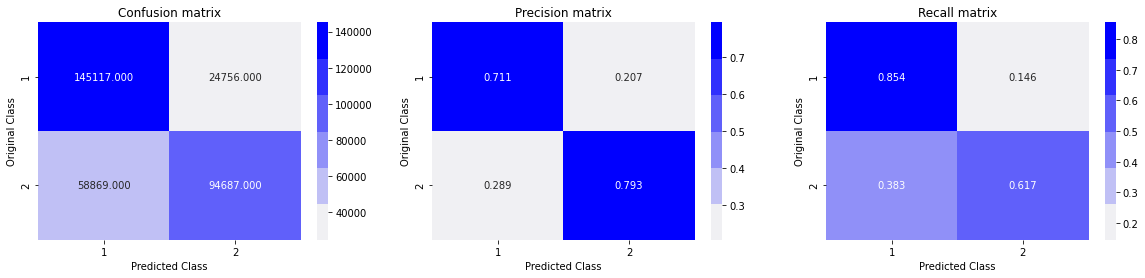

In [ ]:
plot_confusion_matrix(y_train_pred, y_train)

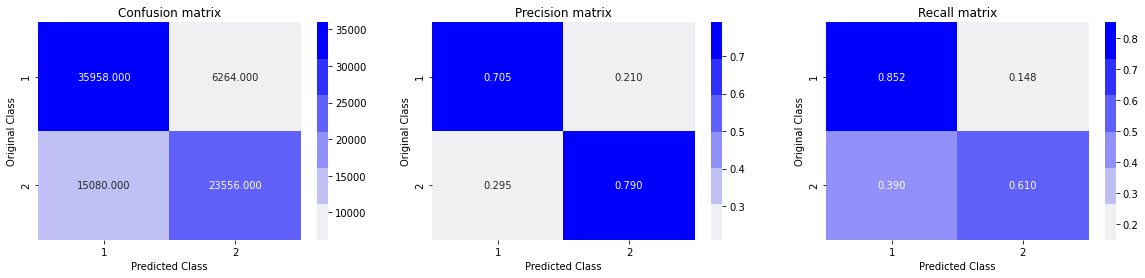

In [ ]:
plot_confusion_matrix(y_test_pred,y_test)

In [ ]:
model_rf = RandomForestClassifier(n_estimators=70, max_depth=8)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
cv_results = cross_validate(model_rf, X_train, y_train, scoring= 'f1_macro',cv=5,return_train_score= True, verbose=3) 
# verbose, print computation process, more number means it will print more frequently
sorted(cv_results.keys())
# ['fit_time', 'score_time', 'test_score']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ................ , score=(train=0.743, test=0.737), total=  28.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.5s remaining:    0.0s


[CV] ................ , score=(train=0.742, test=0.739), total=  29.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV] ................ , score=(train=0.743, test=0.741), total=  28.8s
[CV]  ................................................................
[CV] ................ , score=(train=0.742, test=0.740), total=  28.2s
[CV]  ................................................................
[CV] ................ , score=(train=0.744, test=0.739), total=  29.4s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.6min finished


['fit_time', 'score_time', 'test_score', 'train_score']

In [ ]:
cv_results['test_score'],  cv_results['train_score']

(array([0.73713047, 0.73946462, 0.74106189, 0.74000684, 0.73863709]),
 array([0.74296759, 0.74249289, 0.74343902, 0.74231455, 0.74435926]))

In [ ]:
#y_val_pred= model.predict(X_val)
y_train_pred  = model_rf.predict(X_train)

y_test_pred   = model_rf.predict(X_test)

In [ ]:
prf(y_train, y_train_pred), prf(y_test, y_test_pred)

((array([0.83570753, 0.64368032]),
  array([0.75839518, 0.74537646]),
  array([0.79517657, 0.69080568]),
  array([203986, 119443])),
 (array([0.83382247, 0.63616283]),
  array([0.75149888, 0.74366197]),
  array([0.7905232 , 0.68572489]),
  array([51038, 29820])))

In [ ]:
prf(y_test, y_test_pred)

(array([0.83382247, 0.63616283]),
 array([0.75149888, 0.74366197]),
 array([0.7905232 , 0.68572489]),
 array([51038, 29820]))

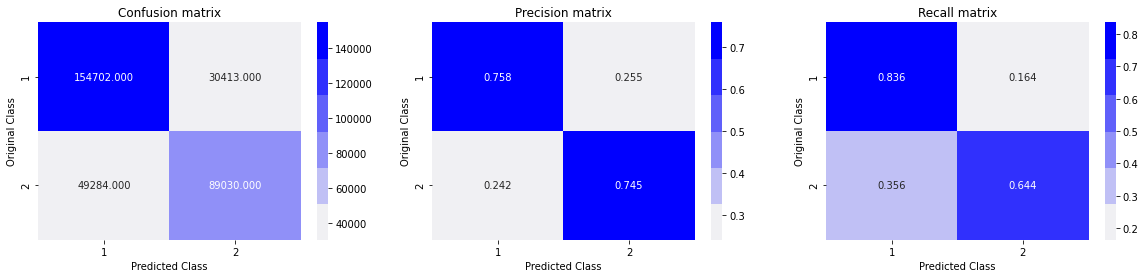

In [ ]:
plot_confusion_matrix(y_train_pred, y_train)

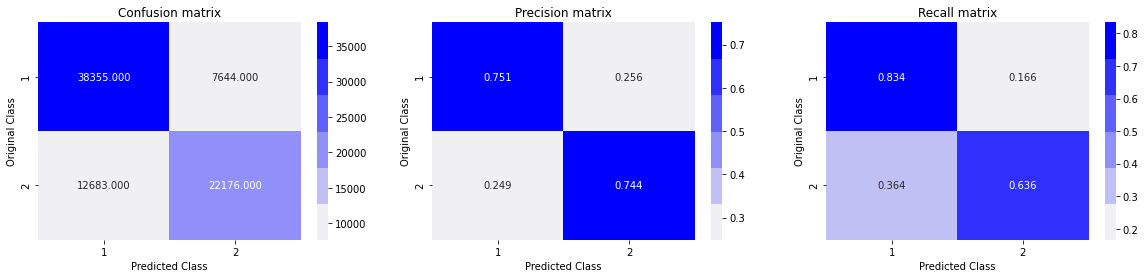

In [ ]:
plot_confusion_matrix(y_test_pred, y_test)

In [ ]:
log_loss(y_test, y_test_pred), log_loss(y_train, y_train_pred)

(8.682874286694656, 8.510913584449591)

In [ ]:
f1_score(y_test, y_test_pred),f1_score(y_train, y_train_pred)

(0.6857248875214521, 0.690805681320003)

# Trying SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier


In [ ]:
from sklearn.metrics import log_loss

In [ ]:
clf= Pipeline(steps=[('scaler', MinMaxScaler()),
                ('sgd', SGDClassifier(penalty='l1'))])


In [ ]:
# cv_results = cross_validate(clf, X_train, y_train, scoring= 'f1_macro',cv=5,return_train_score= True, verbose=3, n_job=-1) 
# # verbose, print computation process, more number means it will print more frequently
# sorted(cv_results.keys())
# # ['fit_time', 'score_time', 'test_score']

In [ ]:
cv_results['test_score'],  cv_results['train_score']

In [ ]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('sgd',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l1', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
#y_val_pred= model.predict(X_val)
y_train_pred  = clf.predict(X_train)

y_test_pred   = clf.predict(X_test)

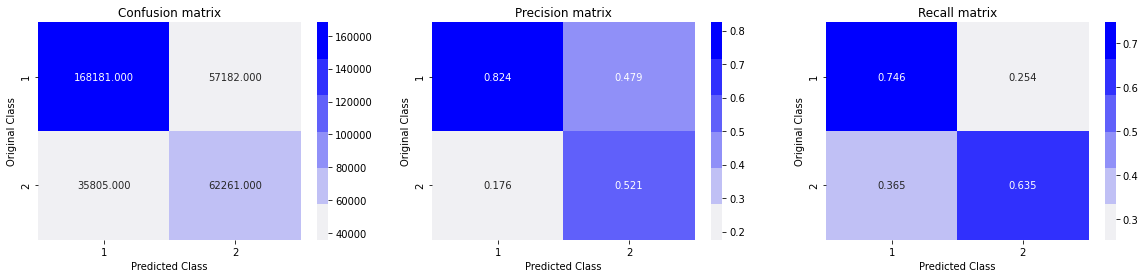

In [ ]:
plot_confusion_matrix(y_train_pred, y_train)

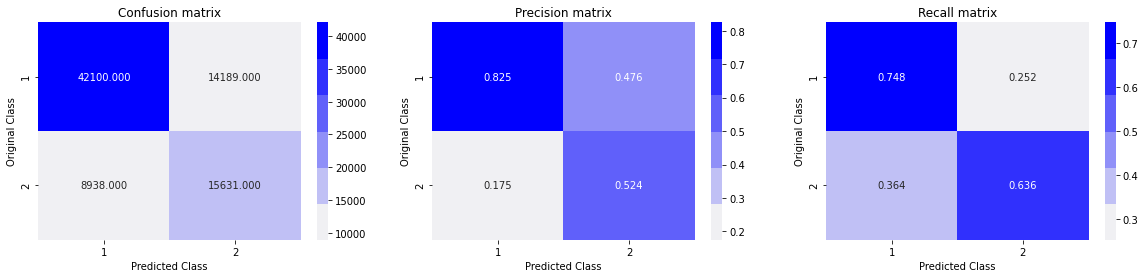

In [ ]:
plot_confusion_matrix(y_test_pred, y_test)

In [ ]:
log_loss(y_test, y_test_pred), log_loss(y_train, y_train_pred)

(9.878867007431925, 9.930110875090199)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_test, y_test_pred)

0.5747853426244277

In [ ]:
f1_score(y_train, y_train_pred)

0.5724912532354983